# __Quantum Machine Learning (QML)__
## Introduction
Quantum Machine Learning combines principles from quantum computing and classical machine learning to potentially enhance learning algorithms using quantum effects. The field can be categorized into four main approaches:

Classical data, Quantum processing (CQ)
Quantum data, Classical processing (QC)
Quantum data, Quantum processing (QQ)
Classical data, Classical processing (CC)

We focus primarily on CQ approaches, particularly quantum-enhanced kernel methods.

<br>

## Core Components
__1. Feature Maps__ <br>
In QML, data encoding is performed through quantum feature maps $\Phi(x)$ that map classical data into quantum states:
$\Phi: x \mapsto |\Phi(x)\rangle = U_{\Phi(x)}|0\rangle^{\otimes n}$
where:

$x$ is classical input data
$U_{\Phi(x)}$ is a quantum circuit parameterized by $x$
$|0\rangle^{\otimes n}$ is the initial quantum state

<br>

__2. Quantum Kernels__ <br>
The quantum kernel is defined as the inner product between feature-mapped states:
$k(x_i,x_j) = |\langle\Phi(x_i)|\Phi(x_j)\rangle|^2$
This can be measured through:

Circuit overlap
Fidelity estimation
Swap test circuits

<br>

__3. Training Methods__ <br>
Two main approaches for quantum-enhanced learning:

Quantum Kernel Estimation:

Classical optimization
Quantum state preparation and measurement
Example: Quantum Support Vector Machines (QSVM)


Variational Quantum Circuits:

Parameterized quantum circuits
Hybrid quantum-classical optimization
Example: Quantum Neural Networks (QNN)

<br>

## Quantum Support Vector Machines
### Theory
QSVM extends classical SVM by using quantum feature maps to potentially access higher-dimensional Hilbert spaces. The optimization problem remains: <br>
$\min_{\gamma} \frac{1}{2}\sum_i\sum_j \gamma^{(i)}\gamma^{(j)}y^{(i)}y^{(j)}K(x^{(i)},x^{(j)}) - \sum_i\gamma^{(i)}$

<br>
where:

- $K(x^{(i)},x^{(j)})$ is the quantum kernel
- $\gamma^{(i)}$ are the Lagrange multipliers
- $y^{(i)}$ are class labels


### Advantages to Classical Approach:

Access to potentially richer feature spaces
Natural handling of quantum data
Possible quantum advantage for specific kernels



### Relationship to Other QML Approaches

__Comparison with VQE:__ Similar variational principles ,Different optimization objectives ,Hardware requirements


__Comparison with QAOA:__ Different problem domains, Similar hybrid approach, Optimization strategies


Create a VQE classifier with Qiskit to perform a binary classification on the following synthetic dataset.

A) Experiment with different ways to preprocess your data.

B) Define a feature map (parameterized QC) that produces a satisfying accuracy in training and test.
You can design your own, or experiment with the prebuilt set of circuits from the [Qiskit Circuit Library](https://docs.quantum.ibm.com/api/qiskit/circuit_library).

Note: 

In this p-set multiple approaches will be valid and lead to good results. Let's share our findings.
You can volunteer to present your apporach in the next lecture.



### __imports + helper functions__

In [1]:
# Qiskit imports
from qiskit.circuit.library import UnitaryOverlap
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import QSVC
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
token = "fa2c930b4dfbc46b54aa6e0f42c7d2b8d3ad024f7e2075f64eed1be44332d8bd07a99189f8ee365a70d9ca30789412d1f61a623f553deebd40c1a5790947379d"

service = QiskitRuntimeService(channel="ibm_quantum",token=token)

In [2]:
def fidelity_circuit(ansatz_1,ansatz_2,display=False):
    """Create a fidelity circuit to estimate the similarity of two states."""
    fc = ansatz_1.copy()
    fc.append(ansatz_2.inverse().decompose(), range(fc.num_qubits))
    fc.measure_all()
    if display == True:
        print(fc.decompose())
    return fc

def plot_matrix(A, title):
    """Plots a given matrix A."""
    plt.title(title)
    ax = plt.imshow(A, cmap='viridis')
    plt.colorbar(ax)
    plt.tight_layout()
    plt.show()

### Data

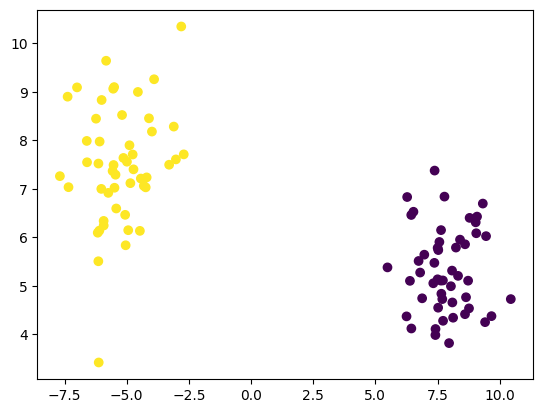

In [8]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature_dim = 2
X,y = make_blobs(n_samples=100, n_features=feature_dim, centers=2)
plt.scatter(X[:,0],X[:,1],c=y)

## __Task 1: Pre-process data using StandardScaler() and AngleEncoding__

I decided to train two models with different preprocessing methods. The two methods are:
<br>

StandardScaler(): Transforms features by removing the mean and scaling to unit variance, ensuring all features are on a similar scale.

AngleEncoding: Converts data points into angles (using arctan2) which can be directly used as rotation parameters in quantum circuits.

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

In [19]:
def angle_encode_2d(X):
    # Create two angles
    angles1 = np.arctan2(X[:, 1], X[:, 0])  # Angle between x and y
    angles2 = np.sqrt(X[:, 0]**2 + X[:, 1]**2)  # Magnitude as second data point
    return np.column_stack((angles1, angles2))


X_angles = angle_encode_2d(X)
X_train_angles, X_test_angles, y_train_angles, y_test_angles = train_test_split(X_angles, y, test_size=0.33)

## __Task 2: Feature Map PauliFeatureMap__

In [10]:
from qiskit.circuit.library import PauliFeatureMap

In [12]:
# Define feature map
feature_map = PauliFeatureMap(2, reps=1, paulis=['Z', 'YY'])
print(feature_map.decompose())

# Setup quantum kernel classifier
sampler = AerSampler()
fidelity = ComputeUncompute(sampler)
kernel = FidelityQuantumKernel(
    feature_map=feature_map,
    fidelity=fidelity
)

qsvc = QSVC(quantum_kernel=kernel)

     ┌───┐┌─────────────┐┌─────────┐                                          »
q_0: ┤ H ├┤ P(2.0*x[0]) ├┤ Rx(π/2) ├──■────────────────────────────────────■──»
     ├───┤├─────────────┤├─────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ Rx(π/2) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├»
     └───┘└─────────────┘└─────────┘└───┘└──────────────────────────────┘└───┘»
«     ┌──────────┐
«q_0: ┤ Rx(-π/2) ├
«     ├──────────┤
«q_1: ┤ Rx(-π/2) ├
«     └──────────┘


### Train and Test

In [13]:
# Train the model
qsvc.fit(X_train_scaled, y_train_scaled)

# Test scores
score_train = qsvc.score(X_train_scaled, y_train_scaled)
print(f"Training score: {score_train}")

score_test = qsvc.score(X_test_scaled, y_test_scaled)
print(f"Test score: {score_test}")

Training score: 0.9850746268656716
Test score: 0.9696969696969697


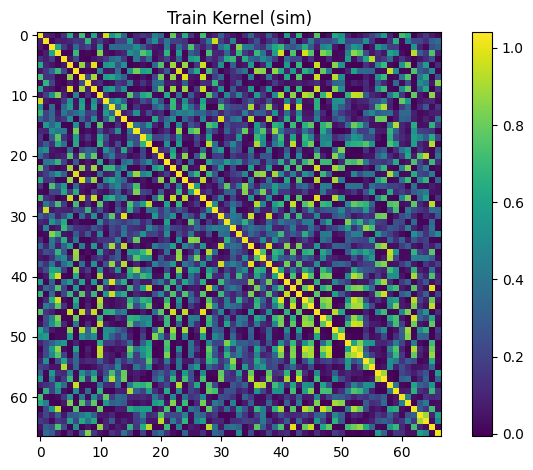

In [14]:
# Visualize kernel matrix
K_train = qsvc.quantum_kernel.evaluate(x_vec=X_train_scaled)
plot_matrix(K_train,title='Train Kernel (sim)')

In [21]:
# Define feature map
feature_map_2 = PauliFeatureMap(2, reps=1, paulis=['Z', 'YY'])
print(feature_map.decompose())

# Setup quantum kernel classifier
sampler = AerSampler()
fidelity = ComputeUncompute(sampler)
kernel = FidelityQuantumKernel(
    feature_map=feature_map,
    fidelity=fidelity
)

qsvc_2 = QSVC(quantum_kernel=kernel)

   
q: 
   


In [ ]:
qsvc_2.fit(X_train_angles, y_train_angles)

# Test scores
score_train_angles = qsvc.score(X_train_angles, y_train_angles)
print(f"Training score: {score_train}")

score_test = qsvc.score(X_test_angles, y_test_angles)
print(f"Test score: {score_test}")

In [ ]:
# Visualize kernel matrix
K_train = qsvc.quantum_kernel.evaluate(x_vec=X_train_scaled)
plot_matrix(K_train,title='Train Kernel (sim)')

### Results

I used the same feature map for both pre-processed data set (I just had to redifine the qsvc because it didn't work otherwise). Therefore, the only difference is with the pre-processing. The results shown a surprisingly good test result for the Standard Scaler 